# Supplementary figure 1
___

In [2]:
library(reshape2)
library(dplyr)

library(ggplot2)
# library(cowplot)

In [3]:
parent <- '/prj/Florian_Leuschner_spatial/analysis/Nanopore/' # change this path!
config <- yaml::yaml.load_file(file.path(parent, 'ScNaST', 'workflow', 'config.yaml', fsep=.Platform$file.sep))

local <- getwd() # you might have to adjust this path to make the local files visible

Number of the Nanopore reads identified by ScNapBar at each processing step (details).
---


In [4]:
# prepare data for plotting
df <- purrr::map2(config$samples, names(config$samples), function(.x, .y) {
    log <- file.path(dirname(.x), 'real.log', fsep=.Platform$file.sep)
    label <- file.path(dirname(.x), 'real.label', fsep=.Platform$file.sep)
    # total reads
    data <- dirname(dirname(.x))
    name <- paste(unlist(strsplit(basename(.x), '.', fixed=T))[1], 'fastq.gz', sep='.')
    total <- system(paste0("awk '{s++}END{print s/4}' ", file.path(data, 'data', name, fsep=.Platform$file.sep)), intern=TRUE)
    # assigned barcodes
    assigned <- system(paste0('wc -l ', label), intern=TRUE)
    # scNapBar log
    x <- read.table(log, sep='\t')
    x <- rbind(c('Total reads', total), x)
    x <- rbind(x, c('Assigned to barcode', unlist(strsplit(assigned, ' '))[1]))
    x[,2] <- as.integer(x[,2])
    x <- mutate(x, Assigned=V2/lag(V2)*100)
    # x <- x[-1,]
    # add sample name
    x$Sample <- toupper(substr(.y, nchar(.y), nchar(.y)))
    x
})
df <- do.call("rbind", df)
df$Sample <-  factor(df$Sample, levels=rev(c('A', 'B', 'C', 'D')))
df$Steps <- factor(df[,1], levels=rev(c('Total reads', 'Aligned to genome', 'Aligned to adapter', 'Aligned to barcode', 'Assigned to barcode')))


x <- na.omit(df)
x <- droplevels(x)
f1 <- ggplot(x, aes(x=Sample, y=Assigned, fill=Steps)) + 
    geom_bar(stat="identity", position=position_dodge()) +
    scale_fill_grey(start=0.8, end=0.2) +
    coord_flip() + 
    labs(x="", y="% Assignment per sample") + 
    geom_text(aes(label=V2), position=position_dodge(width=0.9), hjust=1, color = case_when(
      x$Steps == 'Aligned to genome' ~ "white",
      x$Steps != 'Aligned to genome' ~ "black"
    )) +
    guides(fill = guide_legend(reverse=T,nrow=2)) + 
    theme_minimal() +
    theme(legend.title = element_blank(),
          legend.text=element_text(size=15),
          legend.position = "top",
          panel.grid.major.y = element_blank(),
          axis.text = element_text(size = 18),
          axis.title.x = element_text(size = 18))



Reads or alignment at each step (ScNaST)
---

In [5]:
data <- read.table(file.path(local, 'assignment.txt', fsep=.Platform$file.sep))
data$V1 <- factor(data$V1, levels=rev(c('A', 'B', 'C', 'D')))

f2 <- data %>% melt(id.vars=c('V2', 'V1')) %>% na.omit() %>%
    ggplot(aes(y=V1, x=value, fill=V2)) +
    geom_boxplot(outlier.size=1) +
    labs(x="Reads or alignments per barcode (x1000)", y="") + 
    scale_x_continuous(labels=function(x)x/1000) + 
    scale_fill_grey(start=1, end=.4) +
    guides(fill = guide_legend(reverse=T, nrow=1)) + 
    theme_minimal() +
    theme(legend.title = element_blank(),
          legend.text=element_text(size=15),
          legend.position = "top",
          panel.grid.major.y = element_blank(),
          axis.text = element_text(size = 18),
          axis.title.x = element_text(size = 18))

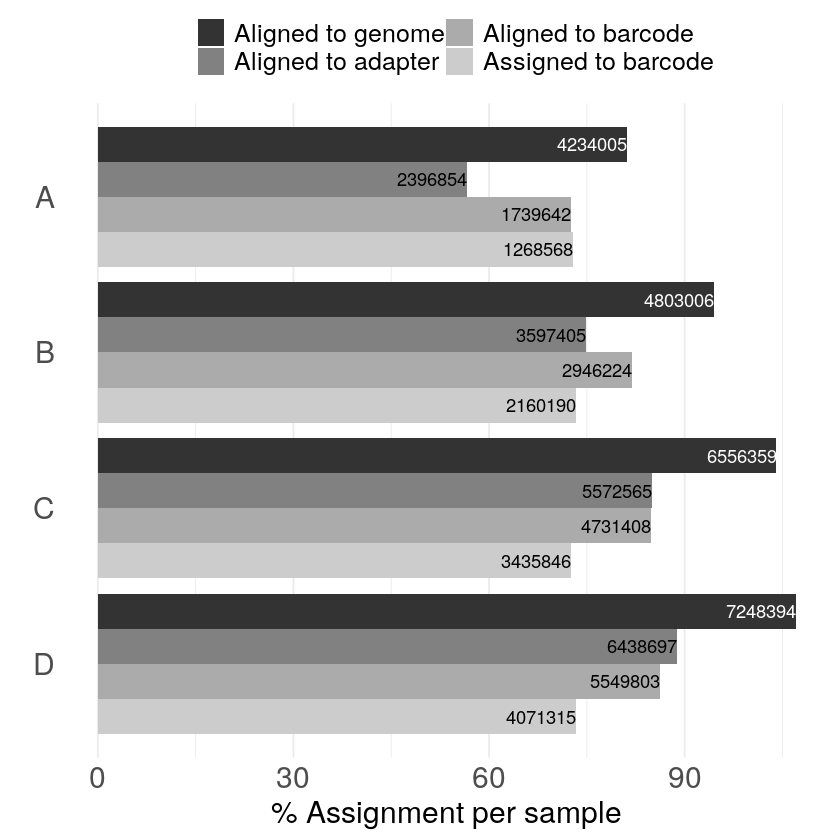

In [6]:
f1

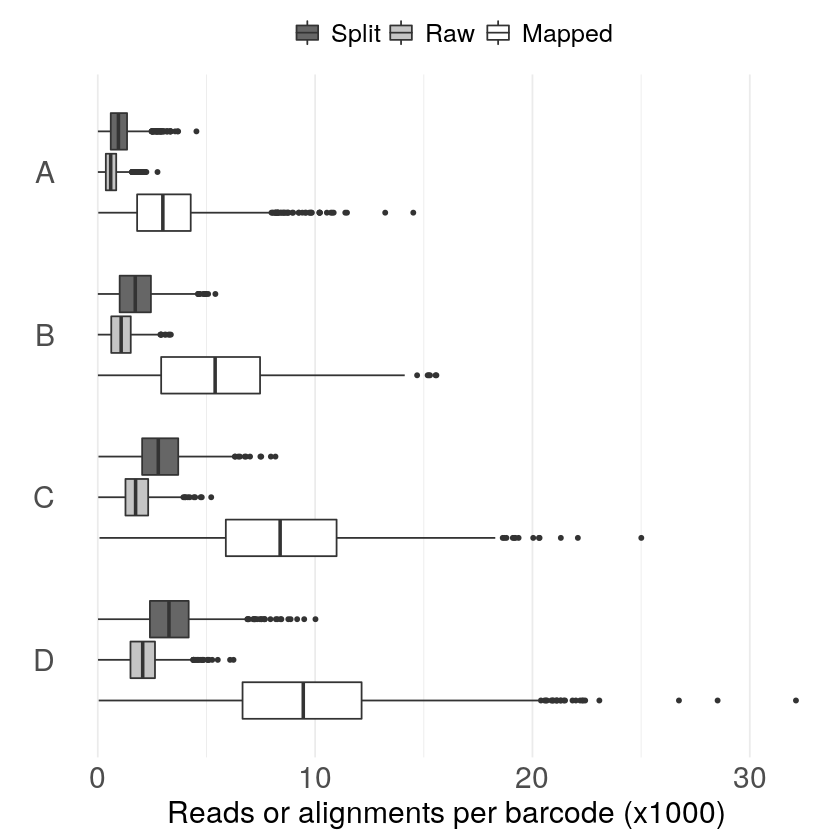

In [7]:
f2

In [ ]:
filen = '/prj/Florian_Leuschner_spatial/analysis/Illumina/data/clusters_bbknn.h5ad'
illumina = sc.read_h5ad(filen)

adata
illumina

In [ ]:
# restrict Nanopore to common set of barcodes for comparison below (counts, etc.), also look at the set of Nanopore-only barcodes

# DECIDE WHICH ONE...
# we should reformat this into the h5 object 
adata.obs_names = adata.obs_names.str.replace('H61211a', 'A1')
adata.obs_names = adata.obs_names.str.replace('H61211b', 'B1')
adata.obs_names = adata.obs_names.str.replace('H61211c', 'C1')
adata.obs_names = adata.obs_names.str.replace('H61211d', 'D1')

# common barcoded
idx = illumina.obs.reindex(adata.obs.index).dropna().index
# nanopore only
nanopore_only_barcodes = adata.obs_names[~adata.obs_names.isin(idx)]
nanopore = adata[adata.obs_names.isin(nanopore_only_barcodes), :]
# common AnnData for Illumina and Nanopore
illumina_matching = illumina[illumina.obs_names.isin(idx), :]
adata_matching = adata[adata.obs_names.isin(idx), :]


In [ ]:
a = illumina_matching.obs[['n_counts', 'n_genes', 'pct_mt']].copy()
a.rename(columns={'n_counts': 'Illumina counts (genes)', 'n_genes': 'Illumina genes', 'pct_mt': 'Illumina MT pct'}, inplace=True)

b = adata_matching.obs[['n_counts', 'n_transcripts', 'pct_mt']].copy()
b.rename(columns={'n_counts': 'Nanopore counts (transcripts)', 'n_transcripts': 'Nanopore transcripts', 'pct_mt': 'Nanopore MT pct'}, inplace=True)

data = pd.concat([a, b], axis=1)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

slope, intercept, r_value, pv, se = stats.linregress(data['Illumina counts (genes)'],data['Nanopore counts (transcripts)'])
# sns.regplot(x="Illumina_counts", y="Nanopore_counts", data=data, 
#       ci=None, label="y={0:.1f}x+{1:.1f}".format(slope, intercept), color='k', scatter_kws={'s':2}).legend(loc="best")
sns.regplot(x="Illumina counts (genes)", y="Nanopore counts (transcripts)", data=data, ax=ax1,
      ci=None, label="R={0:.2}\nP={1:.2}".format(r_value, pv), color='k', scatter_kws={'s':2}).legend(loc="best", frameon=False)

leg = ax1.legend(handlelength=0, handletextpad=0, fancybox=False, frameon=False)
for item in leg.legendHandles:
    item.set_visible(False)
    
slope, intercept, r_value, pv, se = stats.linregress(data['Illumina genes'],data['Nanopore transcripts'])
# sns.regplot(x="Illumina_counts", y="Nanopore_counts", data=data, 
#       ci=None, label="y={0:.1f}x+{1:.1f}".format(slope, intercept), color='k', scatter_kws={'s':2}).legend(loc="best")
sns.regplot(x="Illumina genes", y="Nanopore transcripts", data=data, ax=ax2,
      ci=None, label="R={0:.2}\nP={1:.2}".format(r_value, pv), color='k', scatter_kws={'s':2}).legend(loc="best", frameon=False)

leg = ax2.legend(handlelength=0, handletextpad=0, fancybox=False, frameon=False)
for item in leg.legendHandles:
    item.set_visible(False)
    

slope, intercept, r_value, pv, se = stats.linregress(data['Illumina MT pct'],data['Nanopore MT pct'])
# sns.regplot(x="Illumina_counts", y="Nanopore_counts", data=data, 
#       ci=None, label="y={0:.1f}x+{1:.1f}".format(slope, intercept), color='k', scatter_kws={'s':2}).legend(loc="best")
sns.regplot(x="Illumina MT pct", y="Nanopore MT pct", data=data, ax=ax3,
      ci=None, label="R={0:.2}\nP={1:.2}".format(r_value, pv), color='k', scatter_kws={'s':2}).legend(loc="best", frameon=False)

leg = ax3.legend(handlelength=0, handletextpad=0, fancybox=False, frameon=False)
for item in leg.legendHandles:
    item.set_visible(False)
    
# filen = os.path.join(figloc, f"Illumina_vs_Nanopore_scatter_{illumina_matching.shape[0]}matching_barcodes.png")
filen = os.path.join(outloc, 'results', 'figures', f"Illumina_vs_Nanopore_scatter_{illumina_matching.shape[0]}matching_barcodes.pdf")
fig.savefig(filen, bbox_inches = "tight")

In [ ]:
for lid1, lid2 in zip(['A1', 'B1', 'C1', 'D1'], ['H61211a', 'H61211b', 'H61211c', 'H61211d']):
    
    
    a = illumina_matching.obs[illumina_matching.obs.library_id==lid1].copy()
    a = a[['n_counts', 'n_genes', 'pct_mt']]
    a.rename(columns={'n_counts': 'Illumina counts (genes)', 'n_genes': 'Illumina genes', 'pct_mt': 'Illumina MT pct'}, inplace=True)
    
    b = adata_matching.obs[adata_matching.obs.library_id==lid2].copy()
    b = b[['n_counts', 'n_transcripts', 'pct_mt']]
    b.rename(columns={'n_counts': 'Nanopore counts (transcripts)', 'n_transcripts': 'Nanopore transcripts', 'pct_mt': 'Nanopore MT pct'}, inplace=True)

    data = pd.concat([a, b], axis=1)
    
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

    slope, intercept, r_value, pv, se = stats.linregress(data['Illumina counts (genes)'],data['Nanopore counts (transcripts)'])
    # sns.regplot(x="Illumina_counts", y="Nanopore_counts", data=data, 
    #       ci=None, label="y={0:.1f}x+{1:.1f}".format(slope, intercept), color='k', scatter_kws={'s':2}).legend(loc="best")
    sns.regplot(x="Illumina counts (genes)", y="Nanopore counts (transcripts)", data=data, ax=ax1,
          ci=None, label="R={0:.2}\nP={1:.2}".format(r_value, pv), color='k', scatter_kws={'s':2}).legend(loc="best", frameon=False)

    leg = ax1.legend(handlelength=0, handletextpad=0, fancybox=False, frameon=False)
    for item in leg.legendHandles:
        item.set_visible(False)

    slope, intercept, r_value, pv, se = stats.linregress(data['Illumina genes'],data['Nanopore transcripts'])
    # sns.regplot(x="Illumina_counts", y="Nanopore_counts", data=data, 
    #       ci=None, label="y={0:.1f}x+{1:.1f}".format(slope, intercept), color='k', scatter_kws={'s':2}).legend(loc="best")
    sns.regplot(x="Illumina genes", y="Nanopore transcripts", data=data, ax=ax2,
          ci=None, label="R={0:.2}\nP={1:.2}".format(r_value, pv), color='k', scatter_kws={'s':2}).legend(loc="best", frameon=False)

    leg = ax2.legend(handlelength=0, handletextpad=0, fancybox=False, frameon=False)
    for item in leg.legendHandles:
        item.set_visible(False)


    slope, intercept, r_value, pv, se = stats.linregress(data['Illumina MT pct'],data['Nanopore MT pct'])
    # sns.regplot(x="Illumina_counts", y="Nanopore_counts", data=data, 
    #       ci=None, label="y={0:.1f}x+{1:.1f}".format(slope, intercept), color='k', scatter_kws={'s':2}).legend(loc="best")
    sns.regplot(x="Illumina MT pct", y="Nanopore MT pct", data=data, ax=ax3,
          ci=None, label="R={0:.2}\nP={1:.2}".format(r_value, pv), color='k', scatter_kws={'s':2}).legend(loc="best", frameon=False)

    leg = ax3.legend(handlelength=0, handletextpad=0, fancybox=False, frameon=False)
    for item in leg.legendHandles:
        item.set_visible(False)

    # filen = os.path.join(figloc, f"Illumina_vs_Nanopore_scatter_{illumina_matching.shape[0]}matching_barcodes.png")
    filen = os.path.join(outloc, 'results', 'figures', f"Illumina_vs_Nanopore_scatter_{lid1}.png")
    fig.savefig(filen, bbox_inches = "tight")
    